In [13]:
from differences import ATTgt
from matplotlib import pyplot as plt
plt.rcParams["figure.dpi"] = 300
plt.rcParams['savefig.dpi'] = 300
from panel_utilities import get_value_variable_names, prepare_df_for_DiD
from stats_utilities import select_controls, test_balance, produce_summary_statistics
from figure_utilities import aggregate_by_event_time_and_plot, aggregate_by_time_and_plot
import pandas as pd



# Store paths.
analysis='group_0_crimes_500m'
INPUT_DATA = "../../data/03_cleaned/crime_analysis_monthly.parquet"
OUTPUT_FIGURES = f"../../output/group_0_crimes_warm_500m/figures"
OUTPUT_TABLES = f"../../output/group_0_crimes_warm_500m/tables"


# Read restricted sample panel dataset into memory.
df = pd.read_parquet(INPUT_DATA)

In [14]:
# Convert weekly panel to biweekly panel.
treatment_date_variable = 'latest_docket_month'
df = df.dropna(subset=treatment_date_variable)

# Generate value vars list and month to int dictionaries.
weekly_value_vars_crime, month_to_int_dictionary, int_to_month_dictionary = get_value_variable_names(df, analysis)

In [15]:
pre_pandemic_months = ['2019-04'
                       '2019-11',
                       '2019-12',
                       '2020-01',
                       '2020-02',
                       '2020-03']

df = df.loc[df['latest_docket_month'].isin(pre_pandemic_months), :]

In [16]:
covariates_exploration_df = select_controls(df=df, analysis=analysis,
                                            treatment_date_variable=treatment_date_variable,
                                            output_directory=OUTPUT_TABLES)
covariates_exploration_df

Dependent Variable  \
                                                                                                                  
                                                 \emph{Independent Variable}                                      
Panel A: Pre-treatment Outcomes                  total_twenty_seventeen_group_0_crimes_500m       2.614233e-110   
                                                 pre_treatment_change_in_group_0_crimes_500m       1.442317e-14   
Panel B: Census Tract Characteristics            frac_coll_plus2010                                6.487016e-06   
                                                 job_density_2013                                  2.033950e-22   
                                                 med_hhinc2016                                     2.658108e-09   
                                                 poor_share2010                                    6.942520e-01   
                                                 popdensity2010                                    1.252918e-04   
Panel C: Case Initiation                         for_cause                                         4.815195e-01   
                                                 no_cause                                          4.565814e-02   
                                                 non_payment                                       1.821977e-04   
Panel D: Defendant and Plaintiff Characteristics hasAttyD                                          1.656790e-02   
                                                 hasAttyP                                          9.238225e-01   
                                                 isEntityD                                         1.407778e-01   
                                                 isEntityP                                         5.110915e-01   

                                                                                                        
                                                                                                        
                                                 \emph{Independent Variable}                            
Panel A: Pre-treatment Outcomes                  total_twenty_seventeen_group_0_crimes_500m   0.553883  
                                                 pre_treatment_change_in_group_0_crimes_500m  0.259685  
Panel B: Census Tract Characteristics            frac_coll_plus2010                           0.932705  
                                                 job_density_2013                             0.732177  
                                                 med_hhinc2016                                0.111115  
                                                 poor_share2010                               0.656752  
                                                 popdensity2010                               0.228358  
Panel C: Case Initiation                         for_cause                                    0.003803  
                                                 no_cause                                     0.000372  
                                                 non_payment                                  0.035075  
Panel D: Defendant and Plaintiff Characteristics hasAttyD                                     0.000001  
                                                 hasAttyP                                     0.004075  
                                                 isEntityD                                    0.000105  
                                                 isEntityP                                    0.009533

In [17]:
balance_table, pre_treatment_covariates = test_balance(df, analysis, covariates_exploration_df, OUTPUT_TABLES)
balance_table

\
                                             Cases Won by Plaintiff   
Panel A Total Crime Incidents, 2017                     1197.305955   
        Change in Crime Incidents, 2017-2019            -165.188912   
Panel B Bachelor's degree, 2010                            0.314248   
        Job density, 2013                              17004.722095   
        Median household income, 2016                  47424.412731   
        Population density, 2010                       24015.060910   
Panel C Filing without cause                               0.022587   
        Filing for nonpayment                              0.772074   
Panel D Defendant has attorney                             0.010267   

                                             Difference in Cases Won by Defendant  \
                                                                       Unweighted   
Panel A Total Crime Incidents, 2017                                     31.220044   
        Change in Crime Incidents, 2017-2019                           -18.078946   
Panel B Bachelor's degree, 2010                                          0.001347   
        Job density, 2013                                            -1137.351744   
        Median household income, 2016                                 3090.103453   
        Population density, 2010                                      1259.785560   
Panel C Filing without cause                                            -0.053014   
        Filing for nonpayment                                           -0.062978   
Panel D Defendant has attorney                                          -0.065334   

                                                                               
                                              \emph{p}     Weighted  \emph{p}  
Panel A Total Crime Incidents, 2017           0.553883   -56.219886  0.288371  
        Change in Crime Incidents, 2017-2019  0.259685     6.361976  0.693928  
Panel B Bachelor's degree, 2010               0.932705    -0.015449  0.343120  
        Job density, 2013                     0.732177  -958.530518  0.779967  
        Median household income, 2016         0.111115 -2039.141727  0.272053  
        Population density, 2010              0.228358 -1063.477417  0.299518  
Panel C Filing without cause                  0.000372    -0.006488  0.636589  
        Filing for nonpayment                 0.035075    -0.044669  0.145853  
Panel D Defendant has attorney                0.000001    -0.007125  0.513281

In [18]:
# Generate indicators for missing data.

# missing_indicators = add_missing_indicators(df, ['rent_twobed2015'], pre_treatment_covariates)

# Prepare df for use with the differences package.
df = df.reset_index()
df = prepare_df_for_DiD(df=df,
                        analysis=analysis,
                        treatment_date_variable=treatment_date_variable,
                        pre_treatment_covariates=pre_treatment_covariates,
                        missing_indicators=[],
                        value_vars=weekly_value_vars_crime,
                        period_to_int_dictionary=month_to_int_dictionary)

In [19]:
# Run DiD without conditioning on covariates.
att_gt = ATTgt(data=df, cohort_name=treatment_date_variable, freq='2W', base_period='universal')
result = att_gt.fit(formula=analysis, control_group='not_yet_treated', n_jobs=-1)

Computing ATTgt [workers=10]  100%|████████████████████| 368/368 [00:05<00:00, 64.81it/s] 


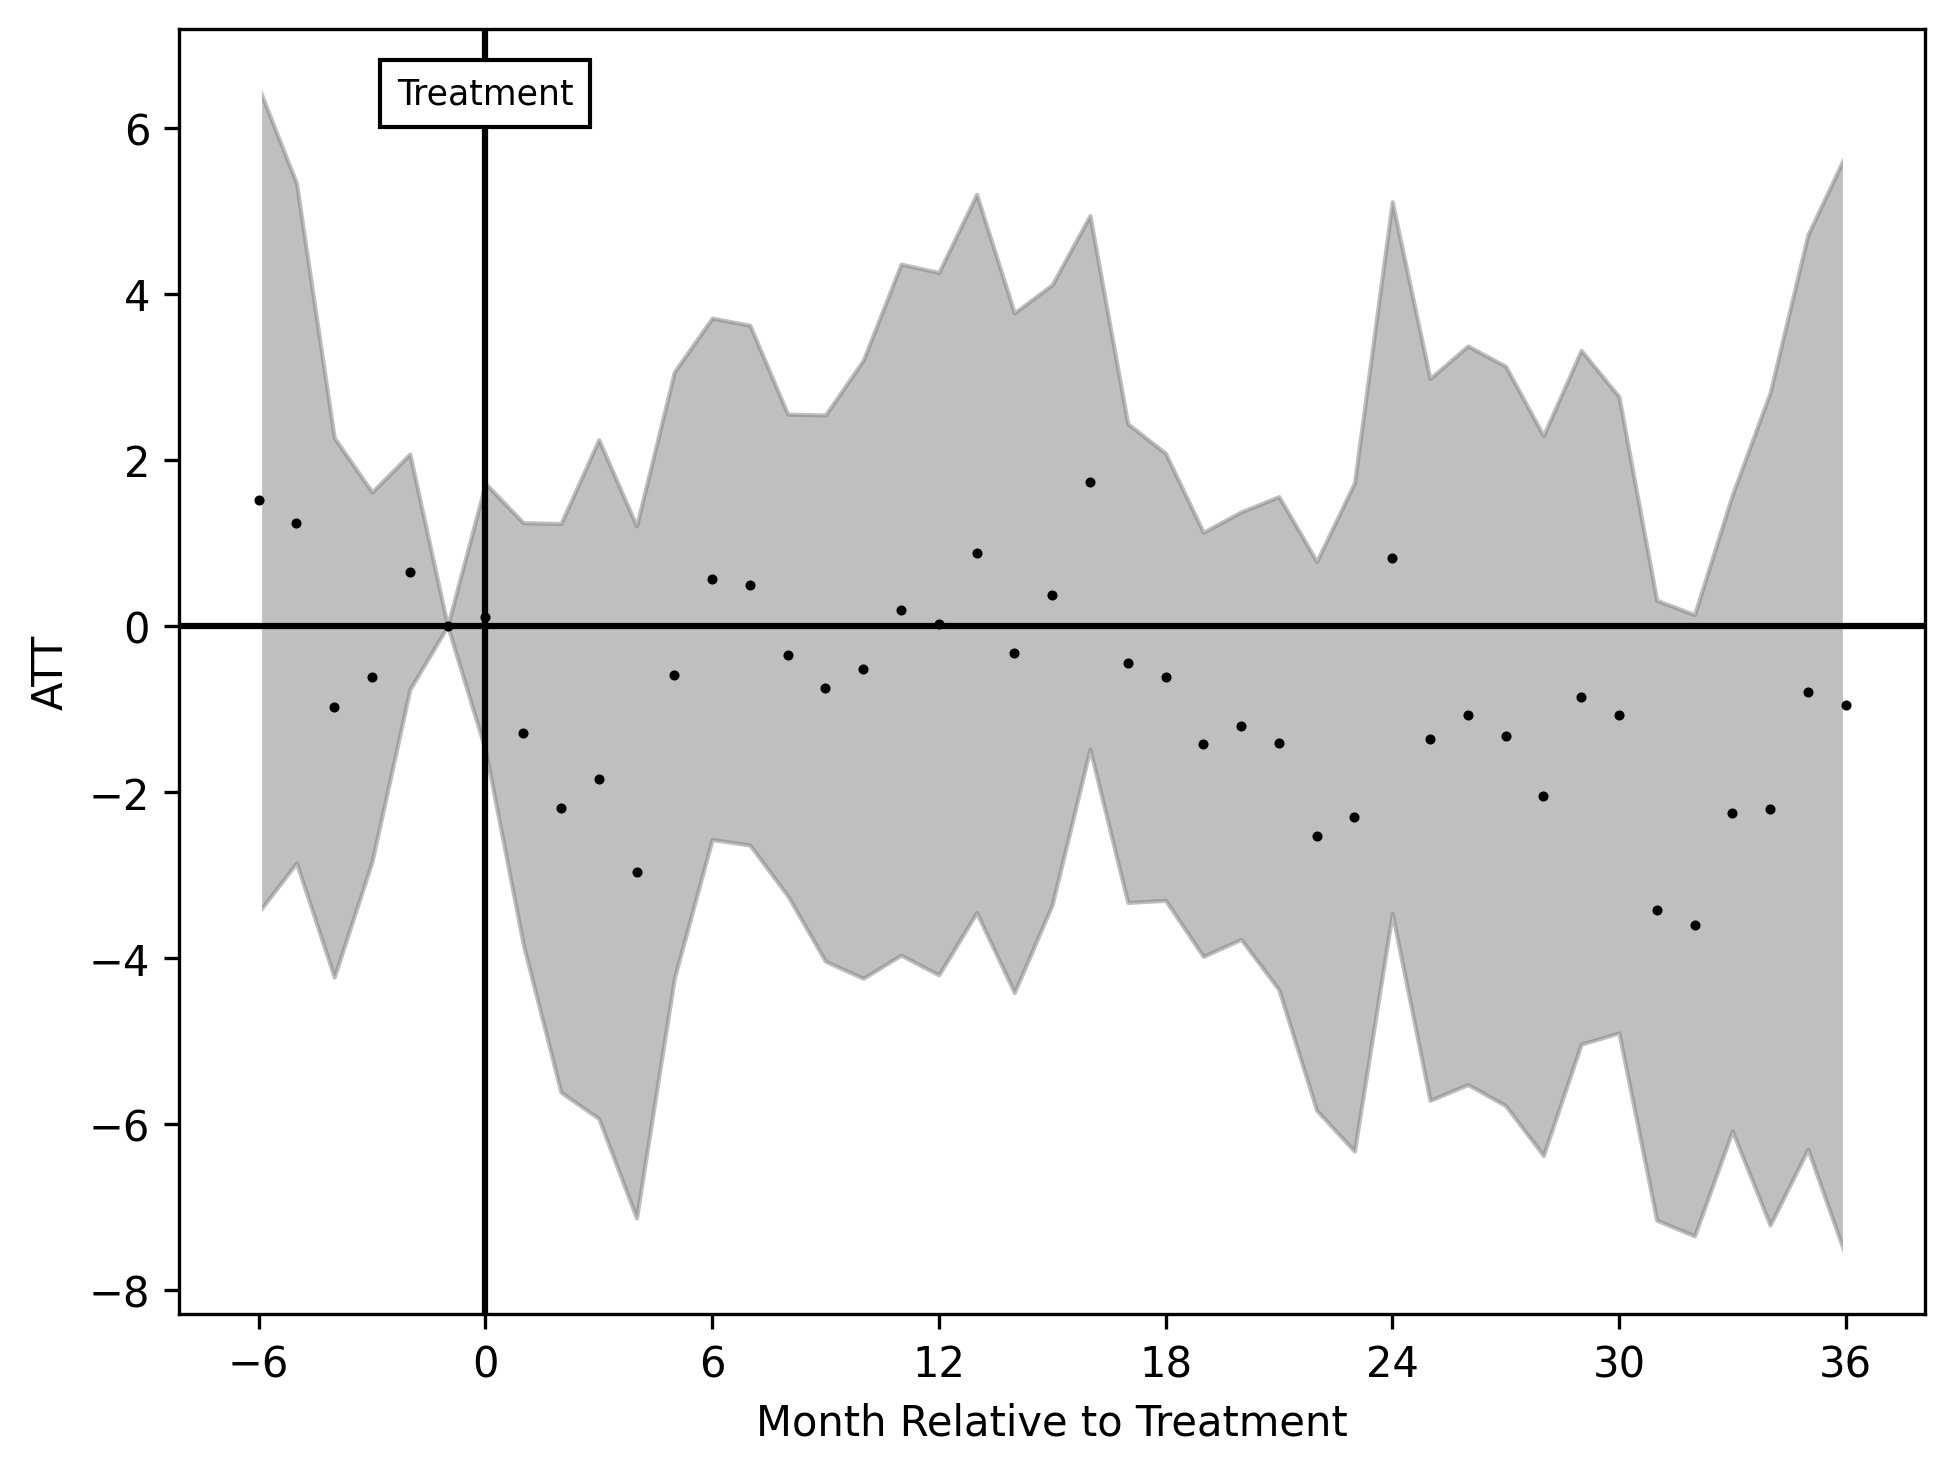

In [20]:
# Plot unconditional ATT(t-g)s on a long horizon.
aggregate_by_event_time_and_plot(att_gt, OUTPUT_FIGURES, "att_gt_unconditional_event_study_long_horizon.png",
                                 start_period=-6, end_period=36,
                                 title="",
                                 treatment_month_variable=treatment_date_variable, df=df)

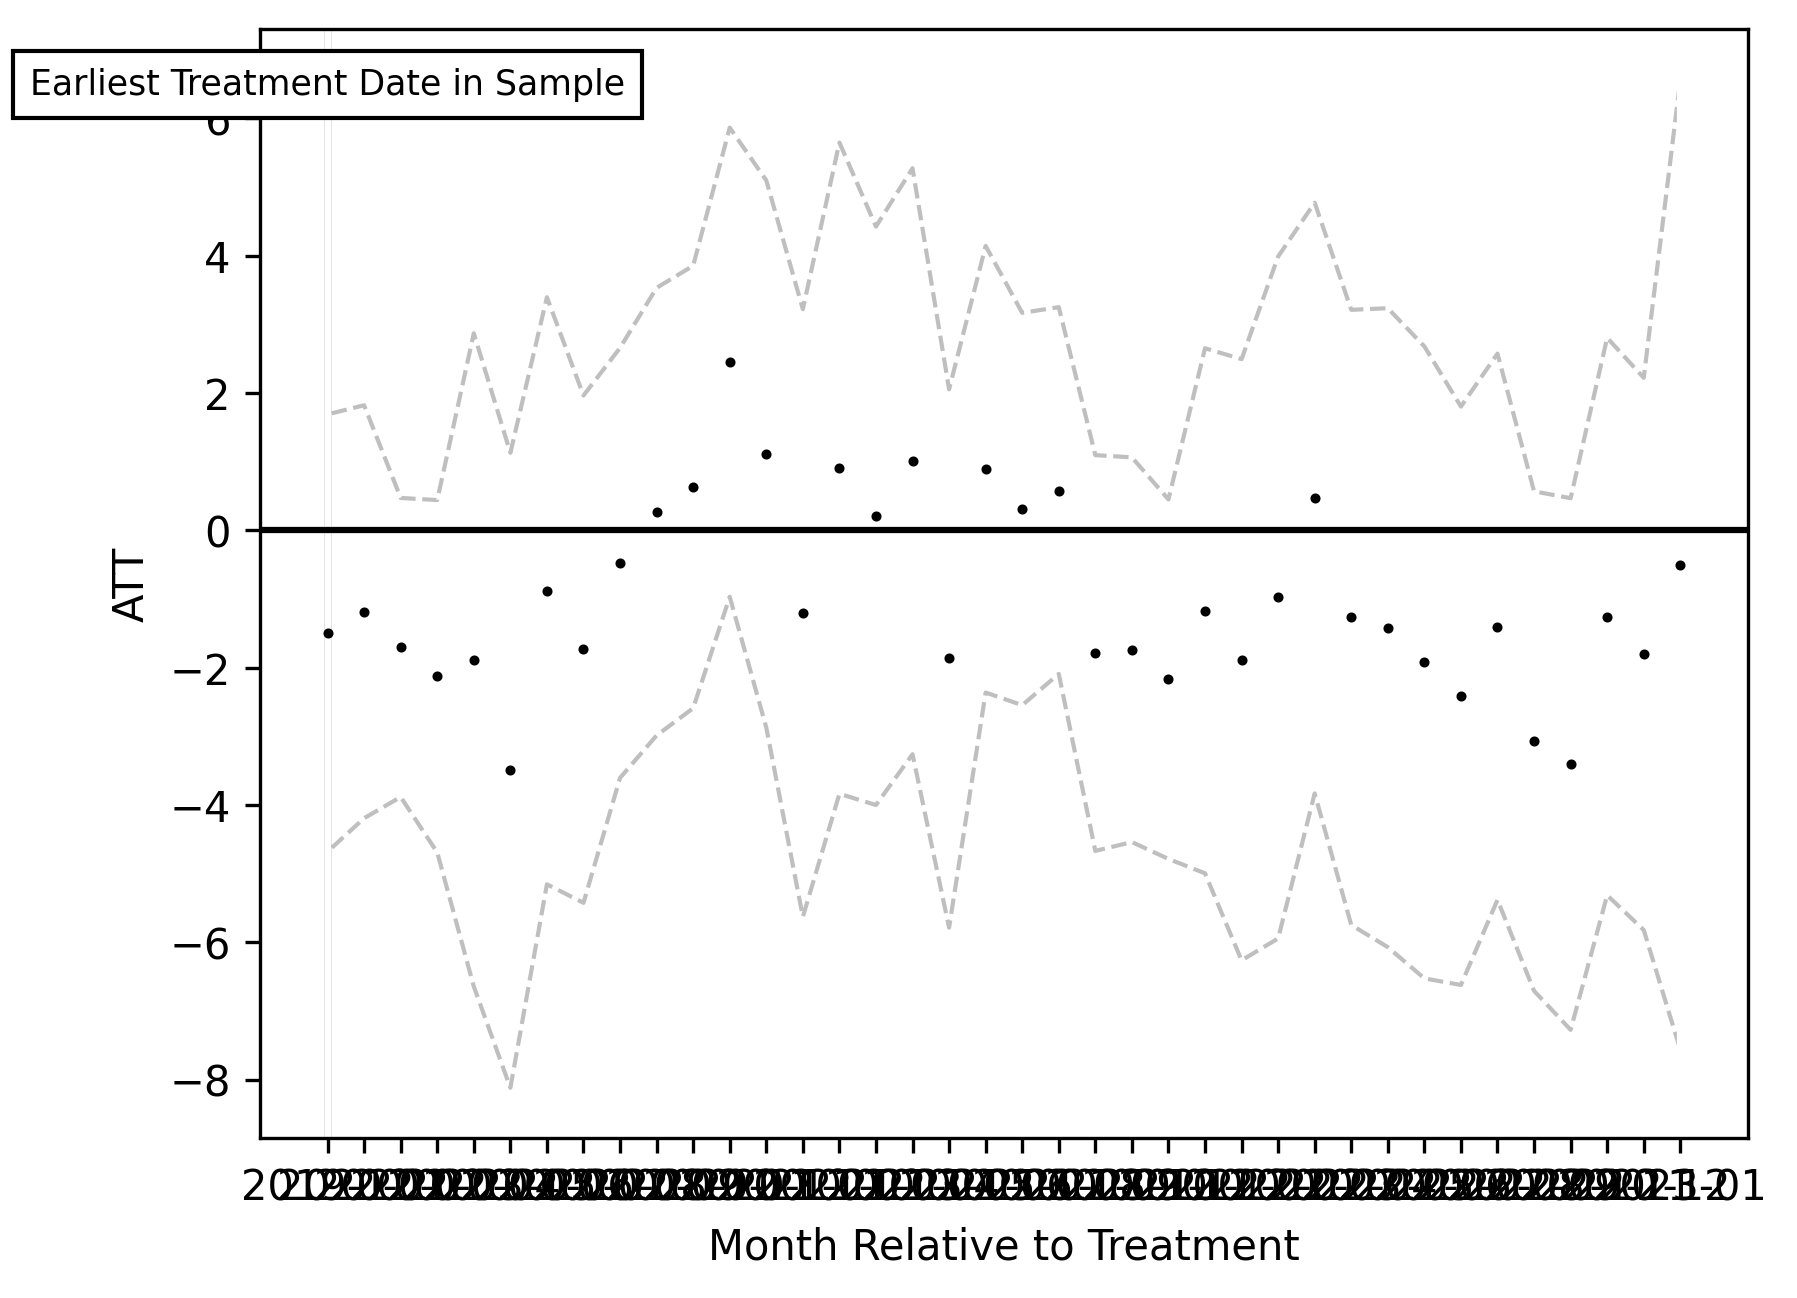

In [21]:
# Plot unconditional ATT(t)s.
aggregate_by_time_and_plot(att_gt, int_to_month_dictionary, OUTPUT_FIGURES, "att_gt_unconditional_time.png",
                           title="")

In [22]:
# Run DiD conditional on covariates.
att_gt = ATTgt(data=df, cohort_name=treatment_date_variable, freq='M', base_period='universal')
formula = f'{analysis} ~ ' + '+'.join(pre_treatment_covariates)
result = att_gt.fit(formula=formula, control_group='not_yet_treated', n_jobs=-1, progress_bar=True)

Computing ATTgt [workers=10]  100%|████████████████████| 368/368 [00:12<00:00, 30.58it/s]


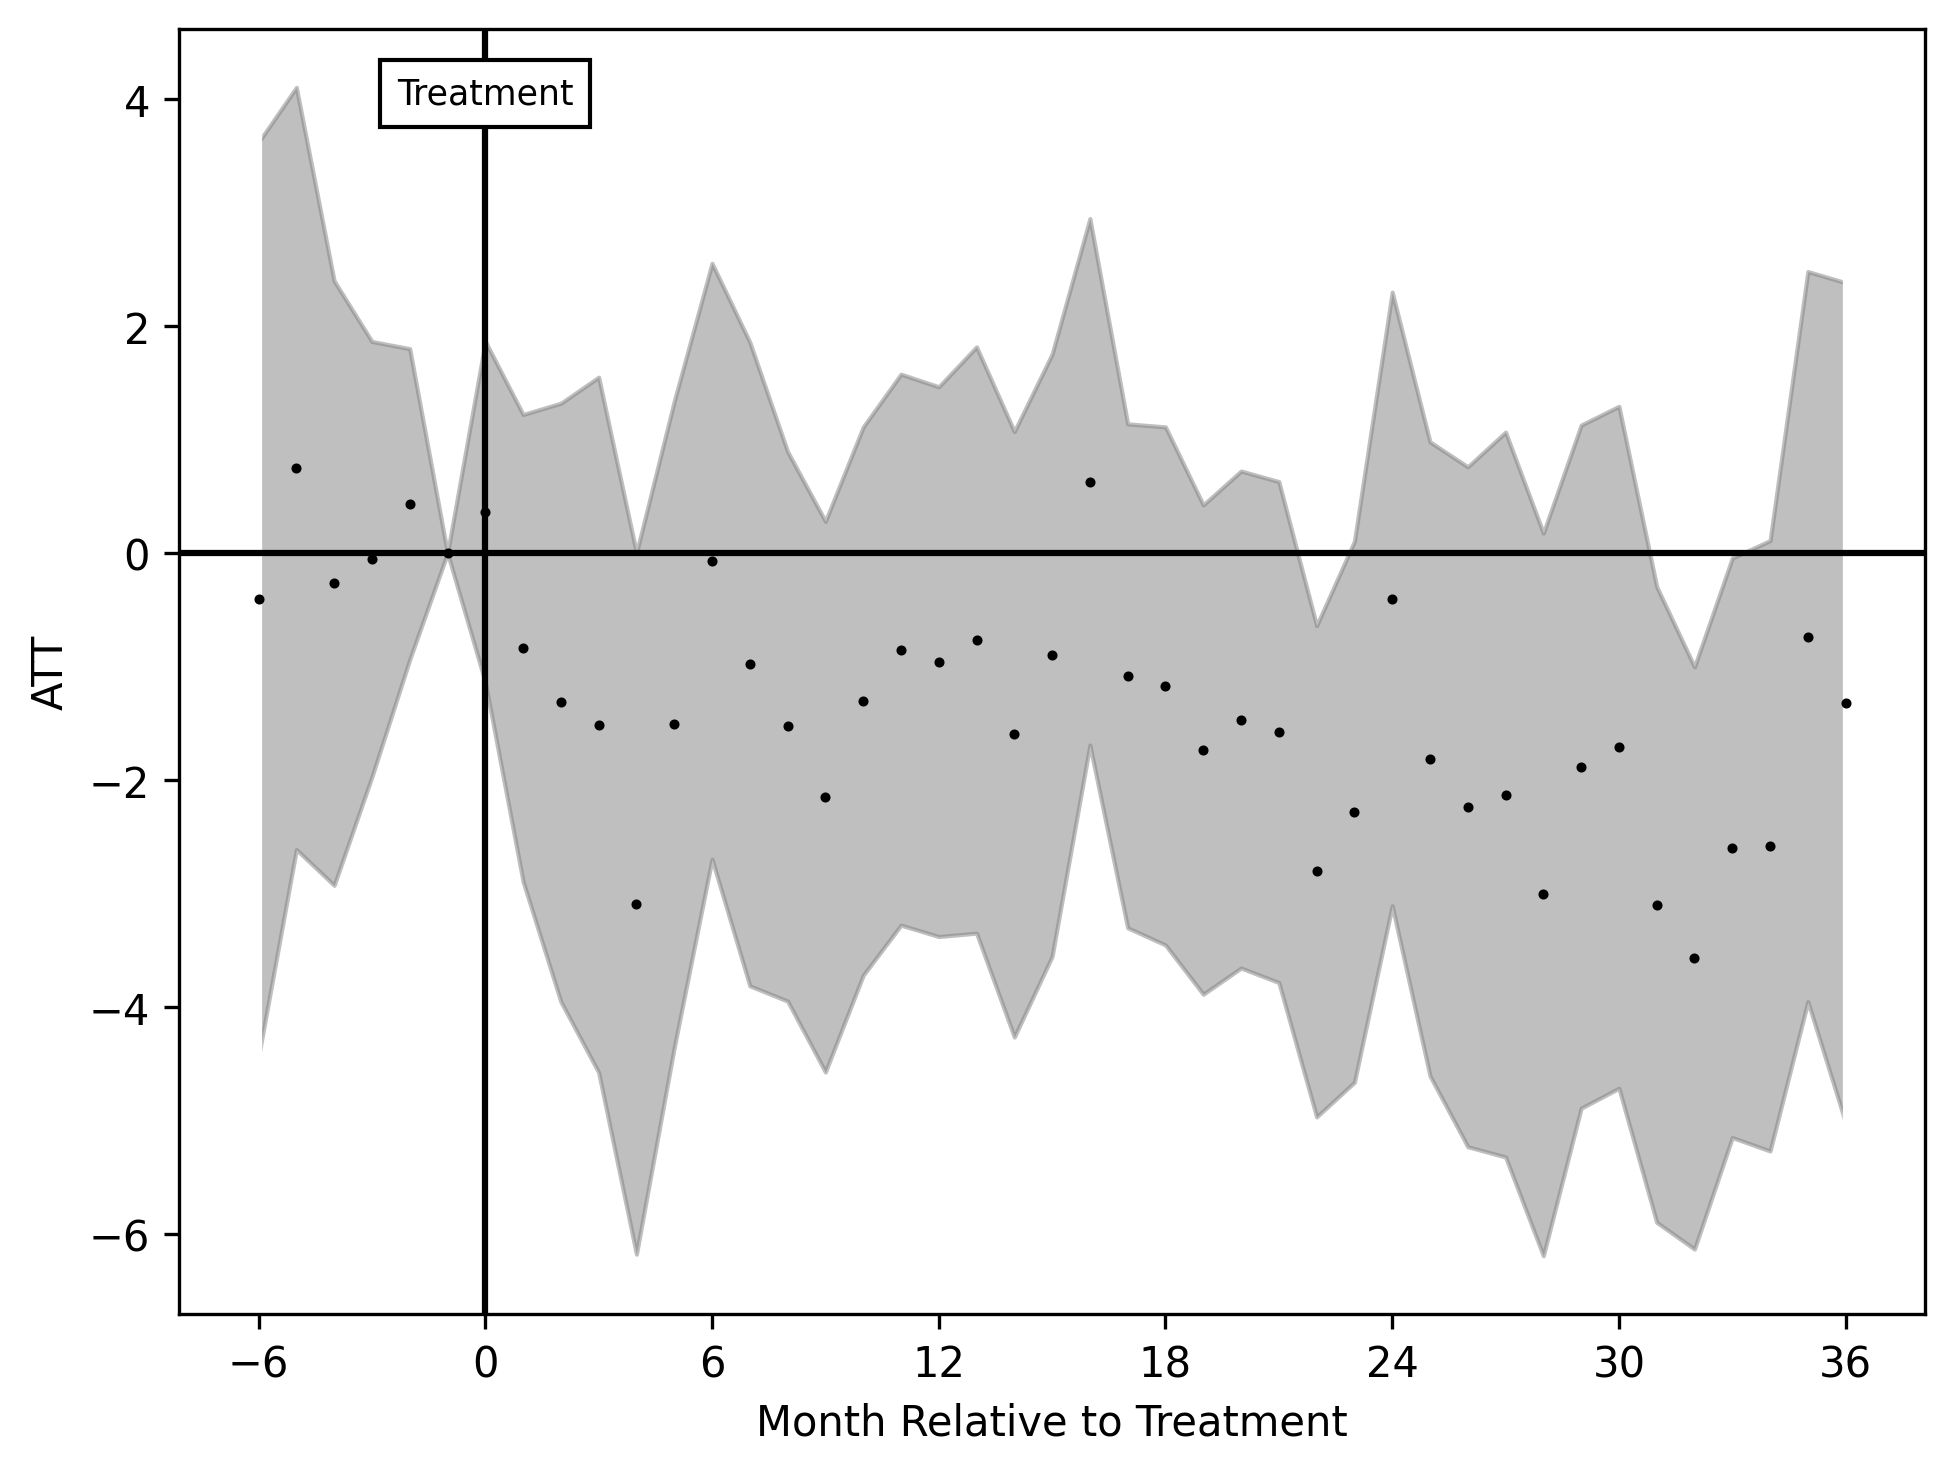

In [23]:
# Plot D.R. ATT(t-g)s on a long horizon.
aggregate_by_event_time_and_plot(att_gt, OUTPUT_FIGURES, "att_gt_dr_event_study_long_horizon.png", start_period=-6,
                                 end_period=36,
                                 title="",
                                 treatment_month_variable=treatment_date_variable, df=df)

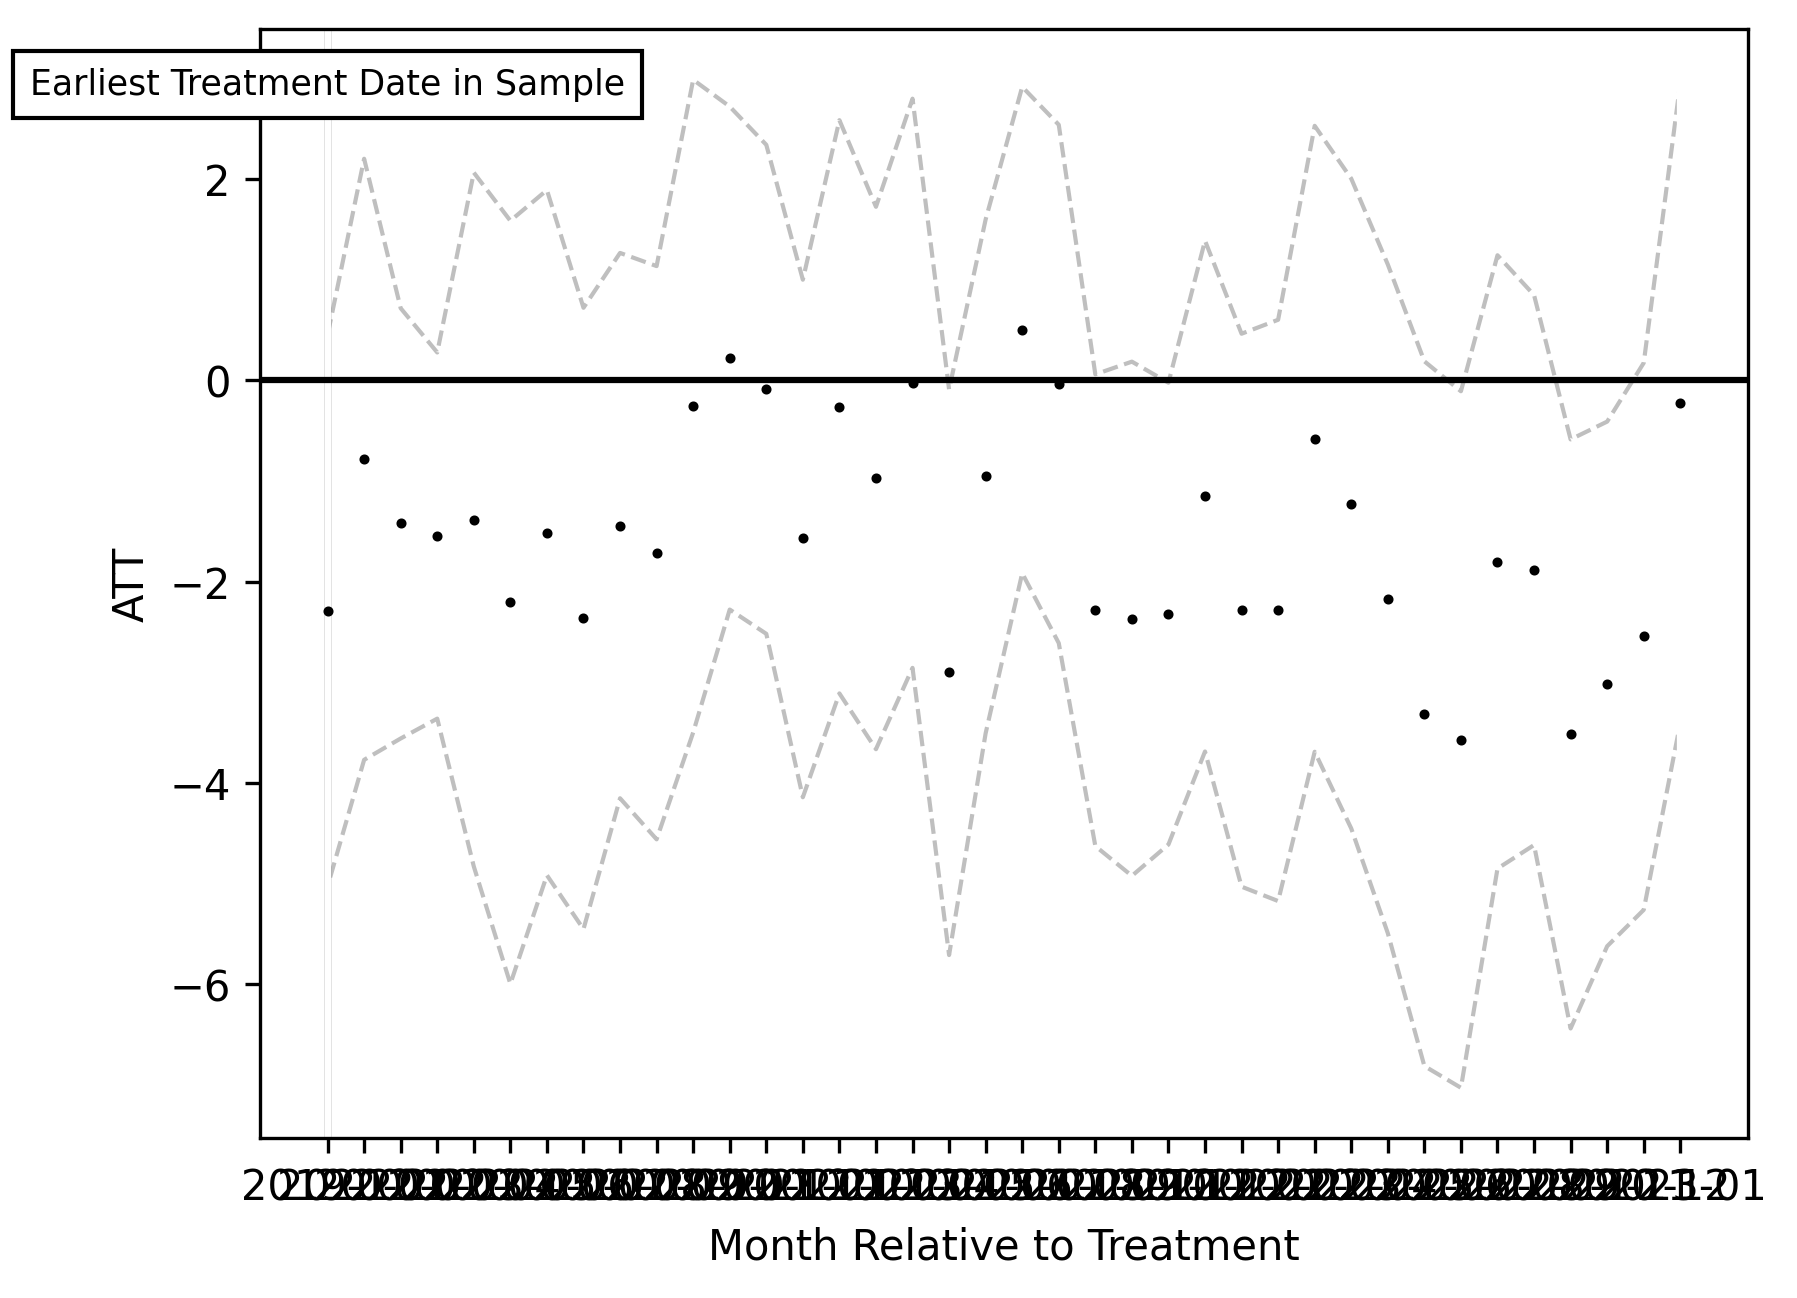

In [24]:
# Plot D.R. ATT(t)s.
aggregate_by_time_and_plot(att_gt, int_to_month_dictionary, OUTPUT_FIGURES, "att_gt_dr_time.png",
                           title="")